## Feature Engineering
- 목적
    - 시간 개념이 들어간 추가 Feature 생성
- 배울 내용
    - BigQuery Window(Analytics) Function
    
- 추가할 Feature
    - 1일(=24시간) 전, 7일(=168시간) 전 해당 zip_code의 수요
    - 여기서 주의할 점
        - 그냥 과거 데이터 기준으로 window 함수 걸고 168시간 전 값을 가져오라고 하면 안됨
        - 혹시나 비어있는 값이 있을수도 있음..!
        - 따라서 비어있지 않은 시간 데이터를 생성한 후, zip_code와 cross join
        - 그 후에 해당 zip_code, datetime별 과거 demand 데이터를 join

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from sklearn.ensemble import RandomForestRegressor
import json

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
ex = Experiment('nyc-demand-prediction', interactive=True)

# experiment_dir가 없으면 폴더 생성하고 FileStorageObserver로 저장
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### 전처리

In [54]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
), distinct_datetime AS (
  # Datetime만 distinct해서 가져옴(비어있지 않을것이라 가정)
  SELECT distinct DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour
  FROM base_data
), distinct_zip_code AS (
  # zip_code만 distinct해서 가져옴(이외의 zip_code는 나오지 않을것이라 가정)
  SELECT distinct zip_code
  FROM base_data
), zip_code_datetime_join AS (
  # zip_code와 datetime을 join
  SELECT
    *,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (5, 6) THEN 1 ELSE 0 END AS is_weekend
  FROM distinct_zip_code  
  CROSS JOIN distinct_datetime
), agg_data AS (
  # zip_code, datetime별 수요 
  SELECT 
      zip_code,
      DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
      COUNT(*) AS cnt
  FROM base_data 
  GROUP BY zip_code, pickup_hour
), join_output AS (
  # zip_code, datetime 데이터에 수요값을 붙이고 없다면 0처리
  select 
    zip_code_datetime.*, 
    IFNULL(agg_data.cnt, 0) AS cnt
  from zip_code_datetime_join as zip_code_datetime
  LEFT JOIN agg_data
  ON zip_code_datetime.zip_code = agg_data.zip_code and zip_code_datetime.pickup_hour = agg_data.pickup_hour
)
SELECT
  *,
  LAG(cnt, 168) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_7d_cnt,
  LAG(cnt, 336) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING), 2) AS avg_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING), 2) AS avg_21d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING) AS INT64) AS std_14d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING) AS INT64) AS std_21d_cnt
FROM join_output
order by zip_code, pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id='geultto')

INFO - pandas_gbq.gbq -   Elapsed 6.33 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 7.4 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 8.92 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 10.01 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 11.78 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 12.87 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 14.03 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 15.2 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 16.28 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 17.39 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 18.51 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 19.61 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 20.77 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 22.18 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 23.53 s. Waiting...
INFO - pandas_gbq.gbq - Total time taken 63.31 s.
Finished at 2019-11-10 23:43:49.


CPU times: user 16.1 s, sys: 686 ms, total: 16.8 s
Wall time: 1min 3s


In [59]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
278251,14801,2015-01-31 19:00:00,1,31,5,19,1,0,0.0,0.0,0.01,0.0,0.0,0.0,373
278252,14801,2015-01-31 20:00:00,1,31,5,20,1,0,0.0,0.0,0.01,0.0,0.0,0.0,373
278253,14801,2015-01-31 21:00:00,1,31,5,21,1,0,0.0,0.0,0.01,0.0,0.0,0.0,373
278254,14801,2015-01-31 22:00:00,1,31,5,22,1,0,0.0,0.0,0.01,0.0,0.0,0.0,373
278255,14801,2015-01-31 23:00:00,1,31,5,23,1,0,0.0,0.0,0.01,0.0,0.0,0.0,373


In [60]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [61]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Train / Test 나누기

In [62]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [63]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
278059,14801,2015-01-23 19:00:00,1,23,4,19,1,0,0.0,0.0,0.0,0.0,0.0,0.0,373
278060,14801,2015-01-23 20:00:00,1,23,4,20,1,0,0.0,0.0,0.0,0.0,0.0,0.0,373
278061,14801,2015-01-23 21:00:00,1,23,4,21,1,0,0.0,0.0,0.0,0.0,0.0,0.0,373
278062,14801,2015-01-23 22:00:00,1,23,4,22,1,0,0.0,0.0,0.0,0.0,0.0,0.0,373
278063,14801,2015-01-23 23:00:00,1,23,4,23,1,0,0.0,0.0,0.0,0.0,0.0,0.0,373


- 사용하지 않을 컬럼 삭제

In [64]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [65]:
train_df.head(2)

,month,day,weekday,hour,is_weekend,cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
0,1,1,3,0,0,1221,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,1,3,1,0,1151,NaN,NaN,1221.0,1221.0,NaN,NaN,0


In [66]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [67]:
train_df = train_df.fillna(method='backfill')
test_df = test_df.fillna(method='backfill')

In [68]:
x_train = train_df.copy()
x_test = test_df.copy()

In [69]:
len(x_train)

206448

In [70]:
len(x_test)

71808

- 데이터가 많아진 이유
    - zip_code, datetime별로 빈 값이 많이 생김

### 모델링

In [77]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(mape)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [78]:
@ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [79]:
@ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [80]:
@ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [81]:
%%time
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "66"
INFO - nyc-demand-prediction - Result: {'mape': {'score': nan}, 'mae': {'score': 11.72236937388592}, 'mse': {'score': 4017.5718024454095}}
INFO - nyc-demand-prediction - Completed after 0:00:02


nan
CPU times: user 9.79 s, sys: 231 ms, total: 10 s
Wall time: 2.3 s


In [76]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 177092093}

In [82]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    return output_df

In [84]:
parsing_output(66)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,66,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 435...",11.722369,None,4017.571802


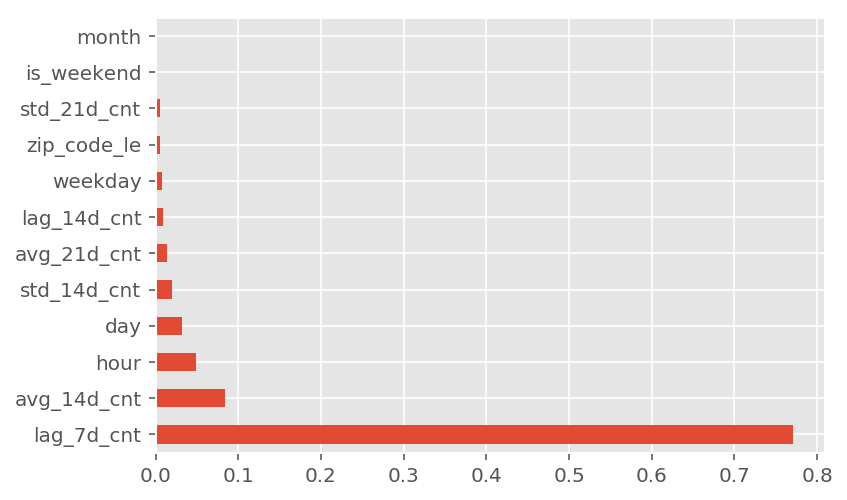

In [85]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

### 결과 분석
- 어떤 알고리즘이 제일 성능이 좋았는지?

In [86]:
parsing_output(57)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,57,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 601...",35.25053,181.914152,12316.4951


In [87]:
parsing_output(66)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,66,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 435...",11.722369,None,4017.571802


### Data 복구
- Label Encoding, 삭제한 데이터, Datetime 등 다시 reverse encoding

In [89]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred
test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [90]:
test_df = test_df.set_index('datetime')

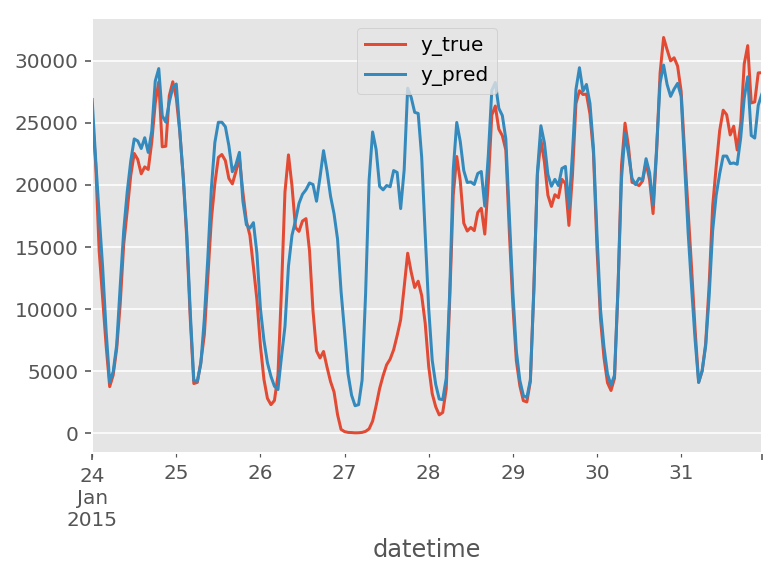

In [91]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot();

In [92]:
def visualize_output_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true', 'y_pred']]
        try:
            ax = data.plot();
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
        
    interact(view_images, zip_code=(10001, 10200))

In [93]:
visualize_output_by_zipcode(test_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…